In [1]:
import sys
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"

###################
# Load other relevant libraries
##################
import fsl.wrappers, statsmodels
from fsl.wrappers import fslmaths
import dipy
import os.path as op
import nibabel as nib
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

In [2]:
%gui wx

In [3]:
# organisation of directory and creation of preprocessing folders
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)



###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap')) 

In [4]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motor_concat_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.par
|--------------- sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz
|--------------- sub-101410_task-motor_func2anat.nii.gz
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|--------------

In [5]:
# define the path
func_path = op.join(bids_root, 'sub-101410', 'func')
mkdir_no_exist(op.join(bids_root, 'sub-001'))
mkdir_no_exist(func_path)

events_LR = op.join(bids_root, "fMRI", "tfMRI_MOTOR_LR", "events_LR.csv")
events_RL = op.join(bids_root, "fMRI", "tfMRI_MOTOR_RL", "events_RL.csv")

# get events data
df_LR = pd.read_csv(events_LR)
df_RL = pd.read_csv(events_RL)

# shift onset for second run so they don't overlap and no duplicates (run1 then run2)
run1_duration = df_LR['onset'].iloc[-1] + df_LR['duration'].iloc[-1]
df_RL['onset'] += run1_duration

# combine them
events = pd.concat([df_LR, df_RL], ignore_index=True)

# renaming for FirstLevelModel
events = events.rename(columns={'condition': 'trial_type'})

events

,onset,duration,trial_type
0,0.0,8.0,NaN
1,8.0,3.0,cue
2,11.0,12.0,rh
3,23.0,3.0,cue
4,26.0,12.0,lf
5,38.0,3.0,cue
6,41.0,12.0,t
7,53.0,3.0,cue
8,56.0,12.0,rf
9,68.0,3.0,cue


In [6]:
# get preprocessed fMRI image which was done in prepocess file 
smoothed_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz")
fmri_img = nib.load(smoothed_path)

In [7]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

motion_param = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_varnorm_moco.par'))
motion_param.keys()

Index(['Rotation x', 'Rotation y', 'Rotation z', 'Translation x',
       'Translation y', 'Translation z'],
      dtype='object')

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


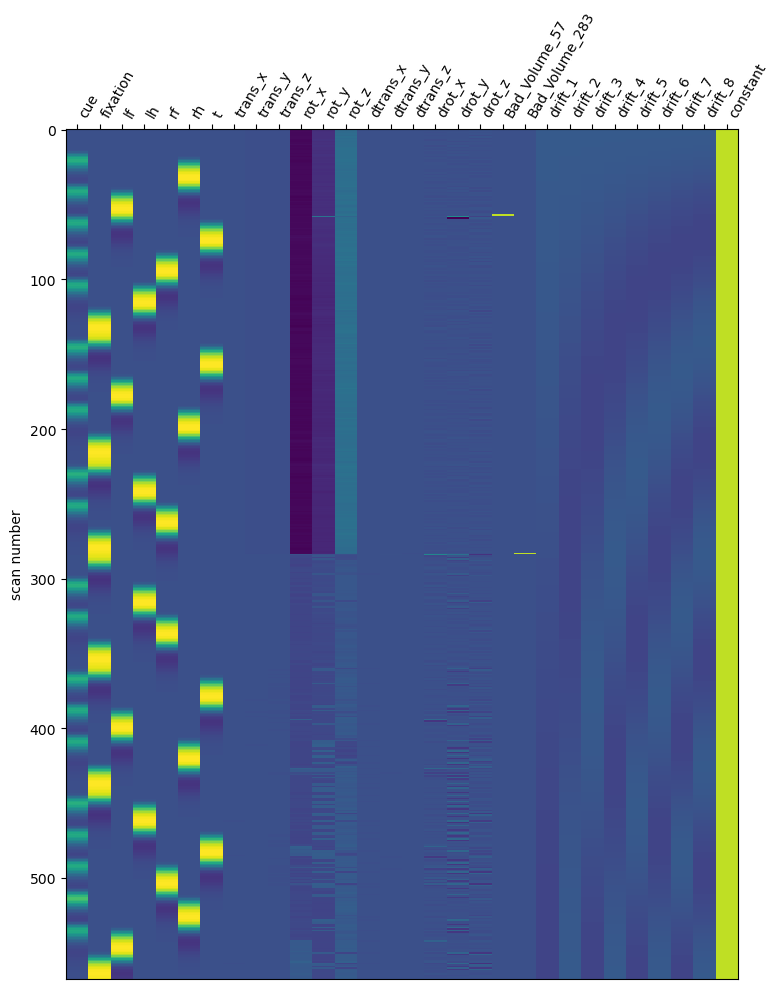

<Figure size 1000x500 with 0 Axes>

In [8]:
##### create basic design matrix
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix

TR = 0.72 # from the .json file

motion_path = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_varnorm_moco.par')
motion_regressors = load_mot_params_fsl_6_dof(motion_path)

# compute de derivative 
motion_derivatives = motion_regressors.diff().dropna()
motion_with_derivatives = pd.concat([motion_regressors, motion_derivatives], axis=1)
motion_with_derivatives.columns = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 
                                   'dtrans_x', 'dtrans_y', 'dtrans_z', 'drot_x', 'drot_y', 'drot_z']

motion_with_derivatives = motion_with_derivatives.fillna(0)

bad_volumes = [57, 283] # outlier volume that we compute also in the preprocess files !
n_scans = fmri_img.shape[-1]

spike_array = np.zeros((n_scans, len(bad_volumes)))
for i, vol in enumerate(bad_volumes):
    spike_array[vol, i] = 1
spike_regressors = pd.DataFrame(spike_array, 
                                columns=[f'Bad_Volume_{vol}' for vol in bad_volumes])
all_regressors = pd.concat([motion_with_derivatives, spike_regressors], axis=1)

design_matrix = make_first_level_design_matrix(
    frame_times=np.arange(n_scans) * TR,
    events=events,
    hrf_model='spm',
    drift_model='cosine',
    high_pass=0.01,
    add_regs=all_regressors.values,
    add_reg_names=list(all_regressors.columns)
)


plot_design_matrix(design_matrix, rescale = False) # rescale = False to avoid the color problem due to outliers
plt.figure(figsize=(10, 5))
plt.show()

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=TR, # from the .json file
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model= 'cosine',
                           high_pass=.01,
                          )

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix)

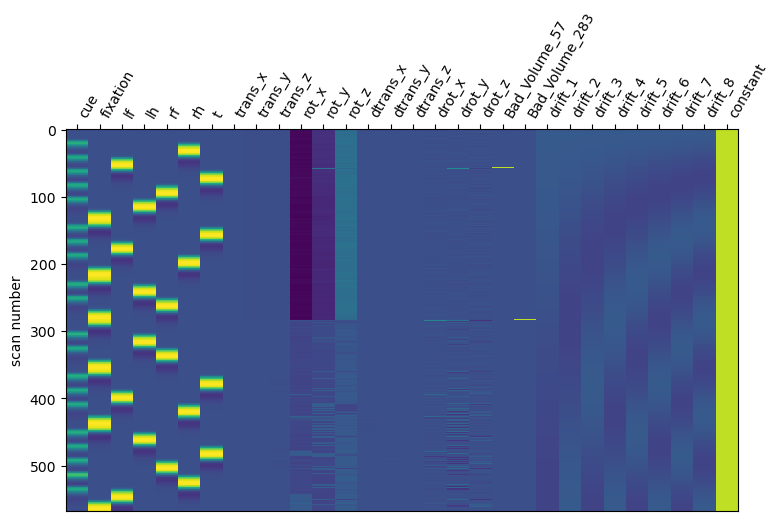

In [9]:
# plot a define size of the desgin matrixc
ax = plot_design_matrix(design_matrix, rescale=False)

ax.set_aspect(0.03)

plt.show()

In [10]:

# Create the dictionary of the conditions
conditions = {
    #'cue': np.array([1, 0, 0, 0, 0, 0, 0 ,0]), 
    #'fixation':np.array([0, 1, 0, 0, 0, 0, 0, 0]),
    'lf': np.array([0, 0, 1, 0, 0, 0, 0 ,0]), 
    'lh':np.array([0, 0, 0, 1, 0, 0, 0, 0]),
    'rf': np.array([0, 0, 0, 0, 1, 0, 0 ,0]), 
    'rh':np.array([0, 0, 0, 0, 0, 1, 0, 0]),
    't': np.array([0, 0, 0, 0, 0, 0, 1 ,0])
}

In [11]:
# get contrast maps
from nilearn.glm import threshold_stats_img
from nilearn.image import mean_img

z_map_lf = fmri_glm.compute_contrast(conditions['lf'],
                                  output_type='z_score')
z_map_lh = fmri_glm.compute_contrast(conditions['lh'],
                                  output_type='z_score')
z_map_rf = fmri_glm.compute_contrast(conditions['rf'],
                                  output_type='z_score')
z_map_rh = fmri_glm.compute_contrast(conditions['rh'],
                                  output_type='z_score')
z_map_t = fmri_glm.compute_contrast(conditions['t'],
                                  output_type='z_score')

# multiple-comparisons : to avoid false positives
cluster_size = 10 
fdr_rate = 0.05

# Here, we apply the FDR correction + threshold
clean_map_lf, threshold_lf = threshold_stats_img(z_map_lf, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_lh, threshold_lh = threshold_stats_img(z_map_lh, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_rf, threshold_rf = threshold_stats_img(z_map_rf, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_rh, threshold_rh = threshold_stats_img(z_map_rh, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_t, threshold_t = threshold_stats_img(z_map_t, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)


mean_img_ = mean_img(fmri_img)

/opt/conda/lib/python3.11/site-packages/nilearn/glm/contrasts.py:108: UserWarning: t contrasts should be of length P=30, but it has length 8. The rest of the contrast was padded with zeros.
  reg = regression_result[label_].Tcontrast(con_val)


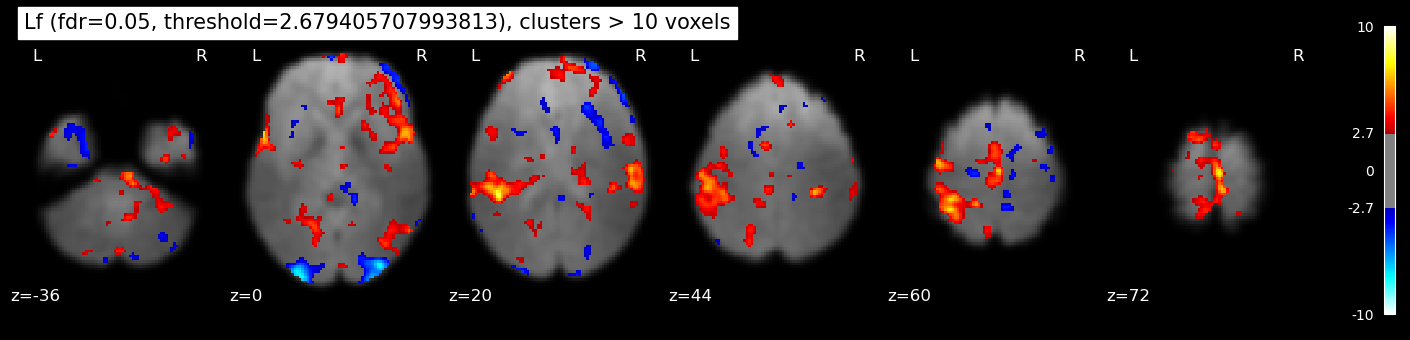

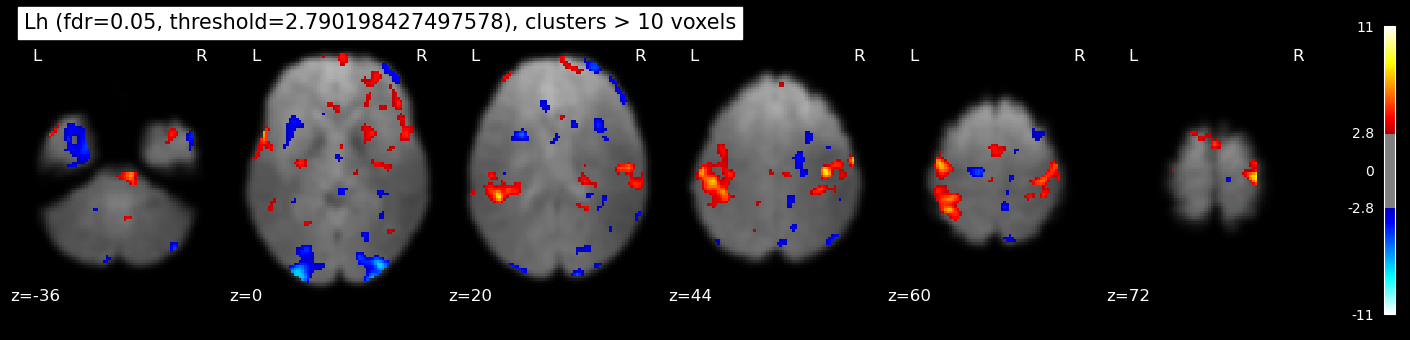

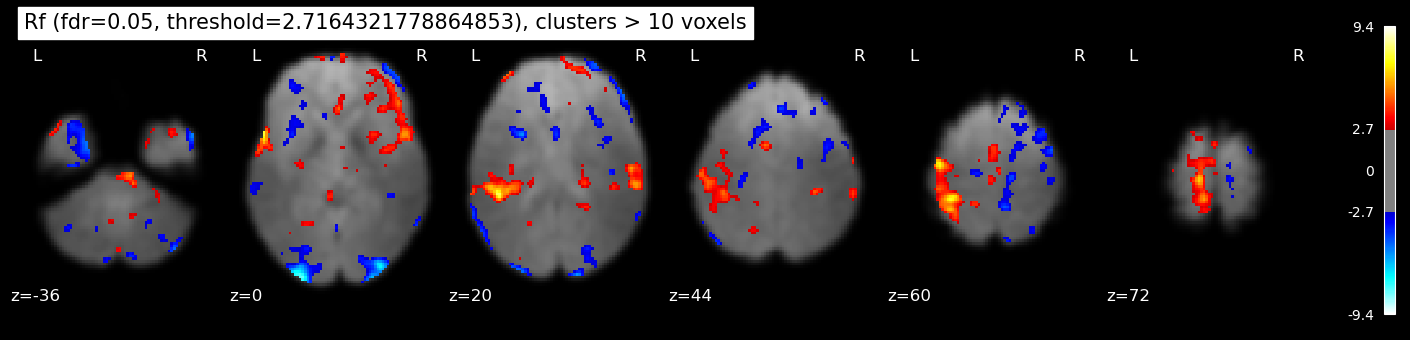

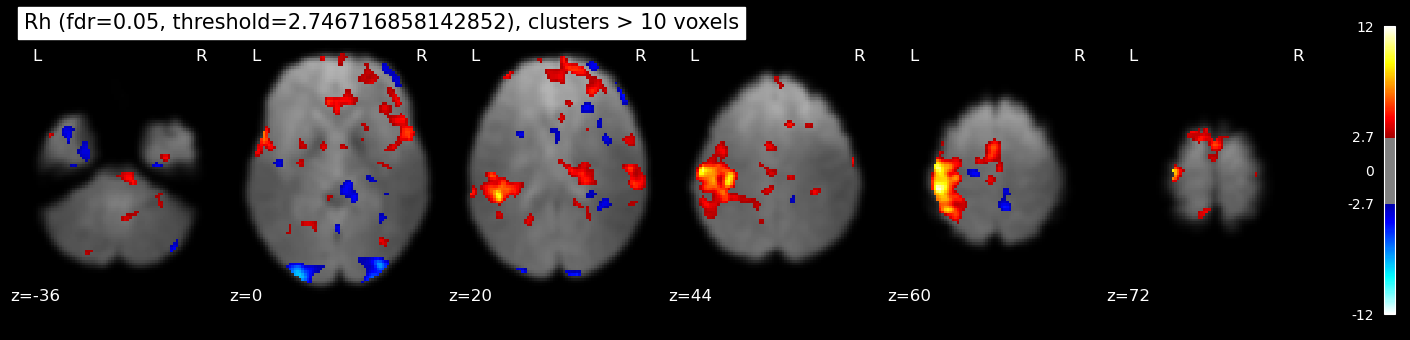

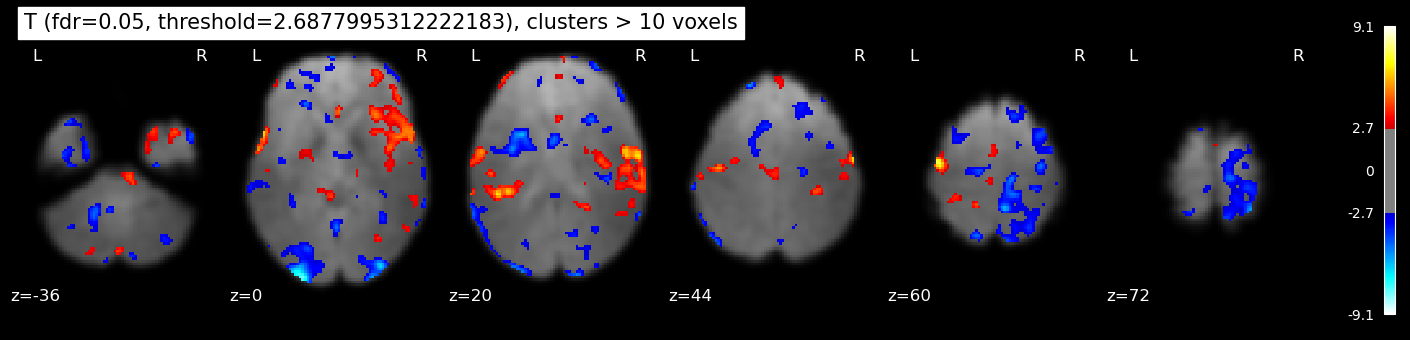

In [12]:
from nilearn.plotting import plot_stat_map

z_maps = {}
thresholds = {}
for condition, contrast_vector in conditions.items():
    z_map = fmri_glm.compute_contrast(contrast_vector, output_type='z_score')
    clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
    z_maps[condition] = clean_map
    thresholds[condition] = threshold

# Compute the mean image for the background
mean_img_ = mean_img(fmri_img)

# Plot for each condition
for condition in conditions:
    plot_stat_map(z_maps[condition], bg_img=mean_img_, threshold=thresholds[condition],
                  display_mode='z', cut_coords=[-36,0,20,44,60,72], black_bg=True,
                  title='{} (fdr={}, threshold={}), clusters > {} voxels'.format(
                      condition.capitalize(), fdr_rate, thresholds[condition], cluster_size))
    plt.show()

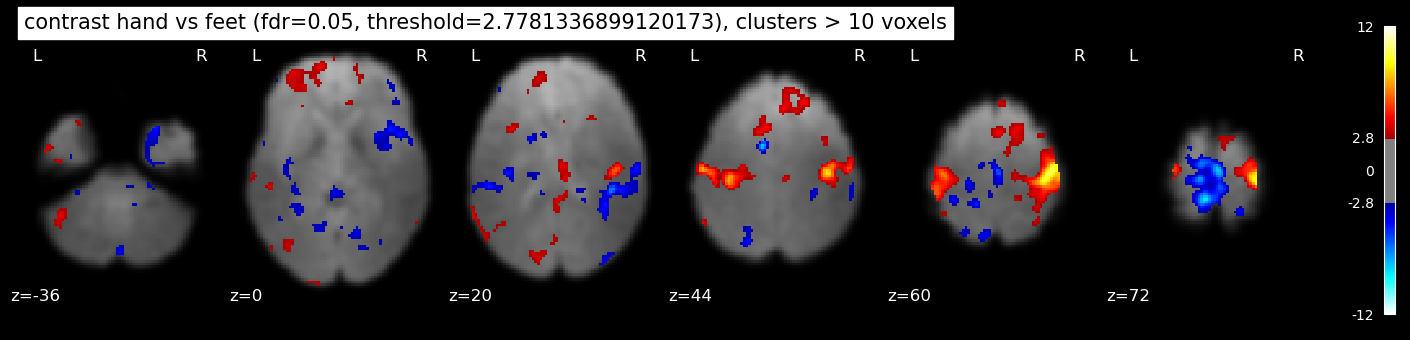

<Axes: label='conditions'>

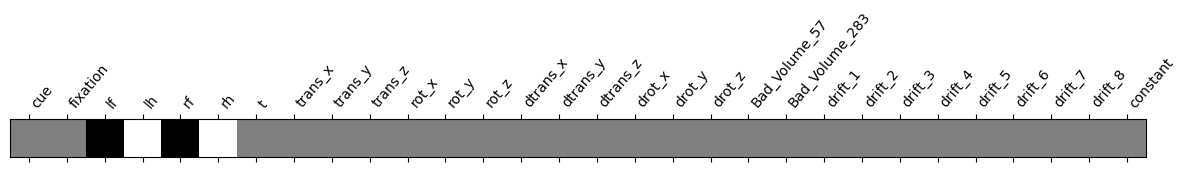

In [13]:
# contrast vector hand vs feet
from nilearn.plotting import plot_contrast_matrix

c_hand_vs_feet =np.array([0,0,-1,1,-1,1,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0,0,0,0,0,0,0,0,0,0])
z_map_hand_vs_feet = fmri_glm.compute_contrast(c_hand_vs_feet, output_type='z_score')

clean_map_hand_vs_feet, threshold_hand_vs_feet = threshold_stats_img(z_map_hand_vs_feet, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

plot_stat_map(clean_map_hand_vs_feet, bg_img=mean_img_, threshold=threshold_hand_vs_feet,
              display_mode='z', cut_coords=[-36,0,20,44,60,72], black_bg=True,
              title='contrast hand vs feet (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold_hand_vs_feet, cluster_size))
plt.show()

plot_contrast_matrix(c_hand_vs_feet, fmri_glm.design_matrices_[0])


Added README.md to /home/jovyan/nilearn_data


Dataset created in /home/jovyan/nilearn_data/aal_SPM12



 ...done. (1 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


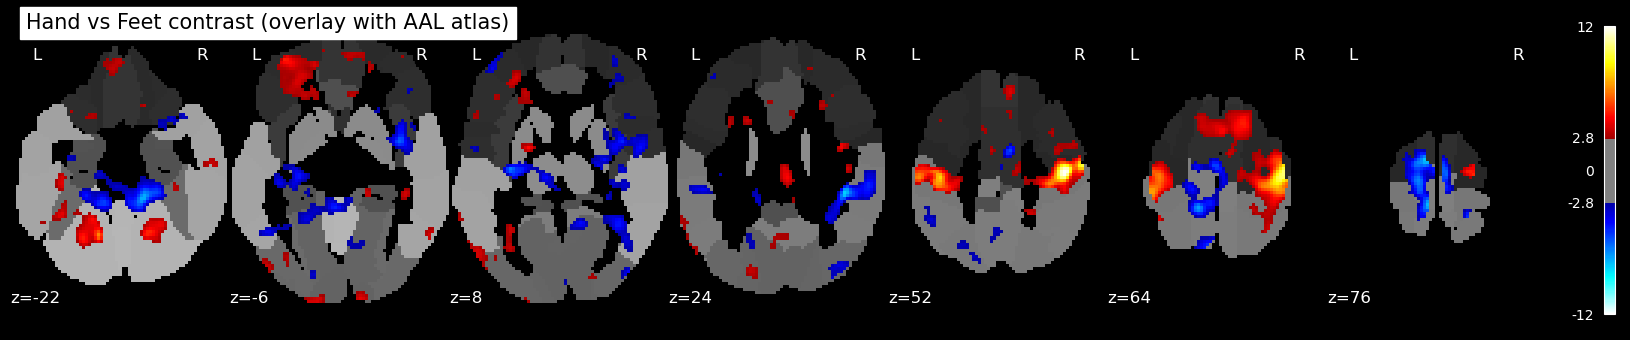

In [14]:
#  overlay with atlas
from nilearn.datasets import fetch_atlas_aal
from nilearn import masking

aal = fetch_atlas_aal(version='SPM12')
aal_img =aal.maps
atlas_labels = aal.labels

plot_stat_map(
    clean_map_hand_vs_feet,
    bg_img=aal_img,
    threshold=threshold_hand_vs_feet,
    display_mode='z',
    cut_coords=7,
    title='Hand vs Feet contrast (overlay with AAL atlas)'
)
plt.show()

In [15]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.maskers import NiftiLabelsMasker

aal = fetch_atlas_aal(version='SPM12')
masker = NiftiLabelsMasker(
    labels_img=aal.maps,
    strategy='mean',               # mean value per region
    standardize=False,
    resampling_target='labels'     # resample z-map to atlas grid
)

# mean z per AAL region (shape: 1 x n_regions)
signals = masker.fit_transform(clean_map_hand_vs_feet)  # uses NaN-safe mean

df = pd.DataFrame({
    'Region': aal.labels,
    'Mean Z-score': signals[0]
}).replace([np.inf, -np.inf], np.nan).dropna()

df = df.sort_values('Mean Z-score', ascending=False)
print(df.head(3))

               Region  Mean Z-score
1        Precentral_R      2.071720
57      Postcentral_R      1.239558
8   Frontal_Mid_Orb_L      0.922734
